# 제주도 버스승차 인원 예측
- ## data 415423 rows × 71 columns
### Columns
- id : 해당 데이터에서의 고유한 id
- data : 날짜
- bus_route_id : 노선 ID
- in_out : 시내버스, 시외버스 구분
- station_code : 해당 승하차 정류소의 id
- station_name : 해당 승하차 정류소의 이름
- latitude : 해당 버스정류장의 위도
- longitude : 해당 버스정류장의 경도
- X-Y_ride : X:00:00 ~ x:59:59까지 승차한 인원 수
- X-Y_takeoff : X:00:00 ~ x:59:59까지 하차한 인원 수
- 18-20_ride : 18:00:00부터 19:59:59까지 승차한 인원 수
- 지번주소 : EDA 및 제주 날씨 merge용 column 
- si :EDA 및 제주 날씨 merge용 column 
- city : EDA 및 제주 날씨 merge용 column  
- dong : EDA 및 제주 날씨 merge용 column  
- road_addr : EDA 및 제주 날씨 merge용 column  
- weather_addr : EDA 및 제주 날씨 merge용 column 
- temperature : 온도
- precipitation : 강수량
- bus_interval : 노선 배차 간격
- date_day : 일 (1일 ~ 30일)
- date_dayofweek : 요일 (0 ~ 6)
- date_dayofname : 요일 (월 ~ 일)
- weekday : 평일 여부
- weekend : 주말 여부
- holiday : 공휴일 여부
- typhoon : 태풍이 온날
- in_ : 시내 버스 구분
- out : 시외 버스 구분
- ridexx : ride(탑승)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- offxx : off(하차)의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ride_sum : 승차인원의 합계
- off_sum : 하차인원의 합계
- bus_route_id_sum : 정류소, 일별 운행한 버스노선의 갯수
- bus_route_id_all_sum : 정류소별 9월 전체 운행한 버스노선의 갯수
- dis_jejusi : 해당 정류장의 제주시에서의 거리 ,맞은편 정류장 merge용 컬럼
- dis_seoquipo : 해당 정류장의 서귀포시에서의 거리,맞은편 정류장 merge용 컬럼
- ac_rideX : 맞은편 정류장의 탑승 인원(6시 ~ 11시)
- ac_offX : 맞은편 정류장의 하차 인원(6시 ~ 11시)
- ac_rideXX : 맞은편 정류장의 탑승의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ac_offXX : 맞은편 정류장의 하차의 2시간 간격 (ex 6시부터 ~7시 까지), 예측하는 y값이 18시 ~ 20시 까지이므로 생성함
- ac_ride_sum : 맞은편 정류장의 승차인원 합계
- ac_off_sum의 : 맞은편 정류장의 하차인원 합계

## 0. 공통

In [1]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pickle
from sklearn.externals import joblib
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import count
import plotly.express as px

import geopy.distance

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [2]:
pd.set_option('max_columns', 700)
pd.set_option('max_rows', 500)

## 1. 데이터 전처리 부분 (컬럼 추가, 삭제 등)

#### 01. 데이터 load

In [3]:
train = pd.read_csv('train.csv',date_parser='date')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [4]:
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


#### 02. 맞은편 정류장의 탑승, 하차 인원 추가

In [5]:
# date 타입 변경
train['date'] = train['date'].astype('datetime64')

In [6]:
# 맞은편 정류장 생성을 위한 제주시와, 서귀포시에서의 거리 측정
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [7]:
def get_station_across():
    
    d2 = train
#     d2 = train.loc[300000:len(train)] ## 데이터 확인용 
    blank = pd.DataFrame()
    
    for i in d2.index:
#         print(str(i)+"/"+ str(len(d2)))
        test = d2.loc[i]
        test_date = d2.loc[i, 'date']
        test_st_name = d2.loc[i, 'station_name']
        test_dis = d2.loc[i, 'dis_jejusi']       
        

        right = d2.query('date == @test_date & station_name == @test_st_name').reset_index()
        right['code'] = abs(right['station_code'] - d2.loc[i, 'station_code'])
        right['standard'] = abs(right['dis_jejusi'] - d2.loc[i, 'dis_jejusi'])
        right['route_id'] = abs(right['bus_route_id'] - d2.loc[i, 'bus_route_id'])

        bag = pd.DataFrame(np.zeros(len(right.columns))).T #26
        bag.columns = right.columns
        bag.station_name = right.station_name
        bag.station_code = right.station_code
        bag.date = right.date
        bag.in_out = right.in_out
        bag.bus_route_id = right.bus_route_id

        
        try:
            A = pd.DataFrame(test).T.merge(pd.DataFrame(right.sort_values(['route_id','code','standard']).reset_index(drop = True).loc[1]).T, on = 'station_name')
        except:
            A = pd.DataFrame(test).T.merge(bag, on = 'station_name')
        
        blank = pd.concat([blank, A])
    blank.drop(['code','standard','index','id_y'], axis = 1, inplace = True)
    blank.reset_index(inplace = True)
    return blank

In [8]:
# train = get_station_across() 해당 코드는 46시간 정도 걸립니다......
# 시간절약을 위해 해당 newtrain.csv 파일을 공유합니다. 
train = pd.read_csv('newtrain.csv')
drop = ['Unnamed: 0', 'level_0', 'index', 'id_y', 'date_y',
        'bus_route_id_y', 'in_out_y', 'station_code_y',
        'latitude_y', 'longitude_y', 'ride18_y', 'dis_jejusi_y',
        'dis_seoquipo_y', 'code', 'standard', 'route_id']
train.drop(drop, axis=1, inplace=True)
train.tail(2)

,id_x,date_x,bus_route_id_x,in_out_x,station_code_x,station_name,latitude_x,longitude_x,ride6_x,ride7_x,ride8_x,ride9_x,ride10_x,ride11_x,off6_x,off7_x,off8_x,off9_x,off10_x,off11_x,ride18_x,dis_jejusi_x,dis_seoquipo_x,ride6_y,ride7_y,ride8_y,ride9_y,ride10_y,ride11_y,off6_y,off7_y,off8_y,off9_y,off10_y,off11_y
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.380000,31.873252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,27.987818,4.828453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# x_컬럼명 변경
x = [i for i in train.columns]
column = []

for item in x:
    item_mod = item.replace("_x", "")
    column.append(item_mod)
train.columns = column

In [10]:
# y_컬럼명 변경
old = ['ride6_y', 'ride7_y', 'ride8_y', 'ride9_y', 'ride10_y', 'ride11_y', 
       'off6_y', 'off7_y', 'off8_y', 'off9_y', 'off10_y', 'off11_y']
y = [i for i in old]
column = []

for item in y:
    item_mod = item.replace("_y", "")
    item_mod2 = 'ac_' + item_mod
    train.rename(columns={f'{item}':f'{item_mod2}'},inplace = True)
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.380000,31.873252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,27.987818,4.828453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### 03. 주소 데이터를 통해, 날씨정보 가져오기

In [11]:
# 주소 데이터 가져오기
jeju_addr=pd.read_csv('jeju_addr.csv')
train = pd.merge(train, jeju_addr, on= 'station_code')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr
415421,400433,2019-09-30,22210000,시내,1585,셰프라인월드,33.43489,126.73242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.813985,25.331042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,제주특별자치도 제주시 구좌읍 송당리 2635-3,제주시,구좌읍,송당리,비자림로
415422,406662,2019-09-30,27180000,시내,3552,행원교차로,33.54574,126.80370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,26.570918,39.113855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 구좌읍 행원리 1180-3,제주시,구좌읍,행원리,일주동로


In [12]:
# 날씨 추가
# date 타입 변경
train['date'] = train['date'].astype('datetime64')

# 날씨 가져오기
#weather 데이터를 추가하기 전 실행해주세요!
jeju=['제주시','애월읍','조천읍']
seogipo=['서귀포시','남원읍','안덕면']
sungsan=['성산읍','구좌읍','우도면','표선면']
gosan=['한경면','한림읍','대정읍']
chuga=['추자면']
weather_addr=[]
for city in train['city']:
    if city in jeju: weather_addr.append('제주')
    elif city in seogipo: weather_addr.append('서귀포')
    elif city in gosan : weather_addr.append('고산')
    elif city in sungsan : weather_addr.append('성산')
    elif city in chuga : weather_addr.append('추자')    
        
#weather_addr 컬럼 생성
train['weather_addr']=weather_addr
weather=pd.read_excel('all_weather.xlsx')
train = pd.merge(train, weather, on= ['weather_addr','date'])
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1


#### 04. 배차간격 추가

In [13]:
# 배차간격 추가 코드 공유, 
# 다만 오래걸리니 완성된 bus_interval_final.csv 파일을 따로 공유합니다.
# 아래에 머지하는 코드를 실행시켜주세요

In [15]:
# 해당코드는 실행하지 말아주세요.
test = pd.read_csv('test.csv')
bts = pd.read_csv('bus_bts.csv')
train['bus_route_id'] = train['bus_route_id'].astype(np.int64)
test['bus_route_id'] = test['bus_route_id'].astype(np.int64)
bts['geton_time2'] = pd.to_datetime(bts['geton_time'])

f = bts.groupby(['geton_date','geton_time2','geton_station_code','bus_route_id'])['user_count'].\
agg([('탑승객_수','sum')]).reset_index().\
sort_values(by=['geton_date','geton_station_code','bus_route_id','geton_time2'], ascending=True).reset_index()

f['index'] = list(range(0,len(f)))

time = []

for i in range(0,len(f)-1):

    if ((f.iloc[i].geton_date == f.iloc[i+1].geton_date) &\
        (f.iloc[i].geton_station_code == f.iloc[i+1].geton_station_code) &\
        (f.iloc[i].bus_route_id == f.iloc[i+1].bus_route_id)):

        time.append(f.iloc[i+1].geton_time2 - f.iloc[i].geton_time2)

    else:
        time.append(0)

time.insert(0, '0')

def get_sec(time_str):

    h, m, s = time_str.split(':')

    return int(h) * 3600 + int(m) * 60 + int(s)

def bus_interval() :

    f['time'] = time
    f['time2'] = f['time'].astype(str).str[7:]


    interval = f.copy()
    interval['time2'] = interval['time2'].astype(str).replace('','00:00:00')
    interval['bus_route_id'] = interval['bus_route_id'].astype(object)

    time4 = []

    for i in interval['time2'] :

        time4.append(get_sec(i))

    interval['time4'] = time4
    interval['time4'] = (interval['time4'] / 60).astype(int)

    interval = interval[interval['time4'] &gt; 3] # 간격이 3분보다 작은 것 제외 
    interval = interval[interval['time4'] &lt; 180] # 간격이 3시간보다 큰 것 제외

    interval = interval.groupby('bus_route_id')['time4'].agg([('bus_interval', 'mean')]).reset_index()
    interval['bus_interval'] = interval['bus_interval'].astype(int)

    # 나중에 시간을 절약하기 위해 csv 파일로 저장
    interval.to_csv('bus_interval_final.csv', index = False)

    print('success.. !')


In [16]:
# 공유되어있는 bus_interval_final.csv 를 여기서 머지해주시면 됩니다.
bus_interval = pd.read_csv('bus_interval_final.csv')
train = pd.merge(train, bus_interval, how='left', on='bus_route_id')
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0


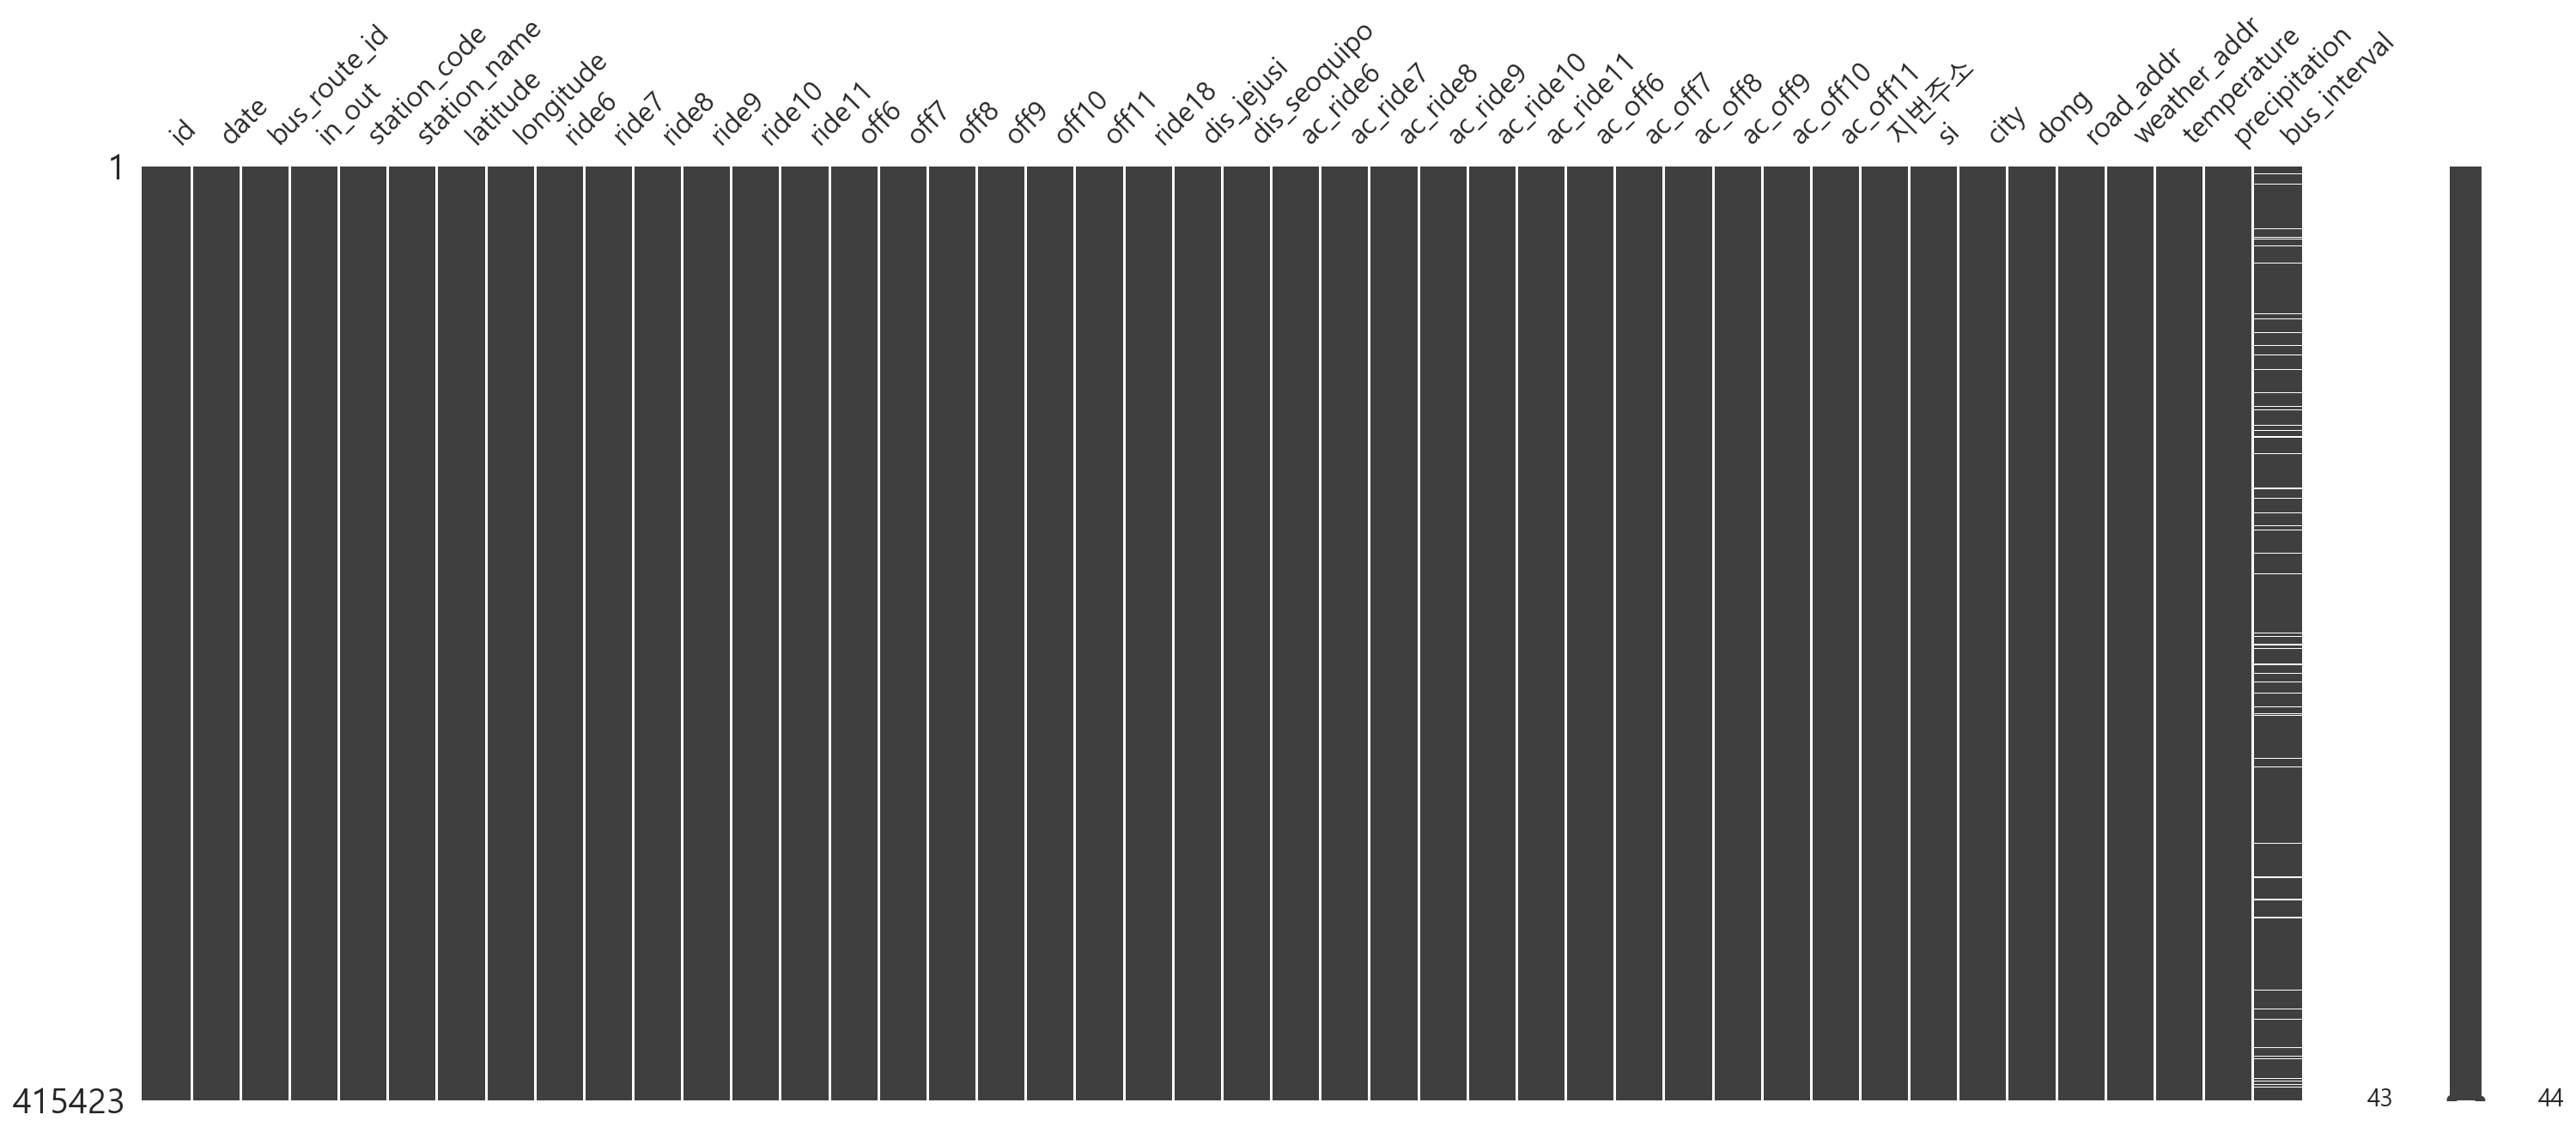

In [17]:
# Nan data 확인
missingno.matrix(train)
plt.show()

In [18]:
# 배차간격에 Nan값 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 44 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  object        
 4   station_code   415423 non-null  int64         
 5   station_name   415423 non-null  object        
 6   latitude       415423 non-null  float64       
 7   longitude      415423 non-null  float64       
 8   ride6          415423 non-null  float64       
 9   ride7          415423 non-null  float64       
 10  ride8          415423 non-null  float64       
 11  ride9          415423 non-null  float64       
 12  ride10         415423 non-null  float64       
 13  ride11         415423 non-null  float64       
 14  off6           415423 non-null  float64       
 15  

In [19]:
# 배차간격이 없는것은 너무오래 안다니는것으로 999로 변경
train['bus_interval'].fillna(999, inplace = True)
train['precipitation'].fillna(0, inplace = True)

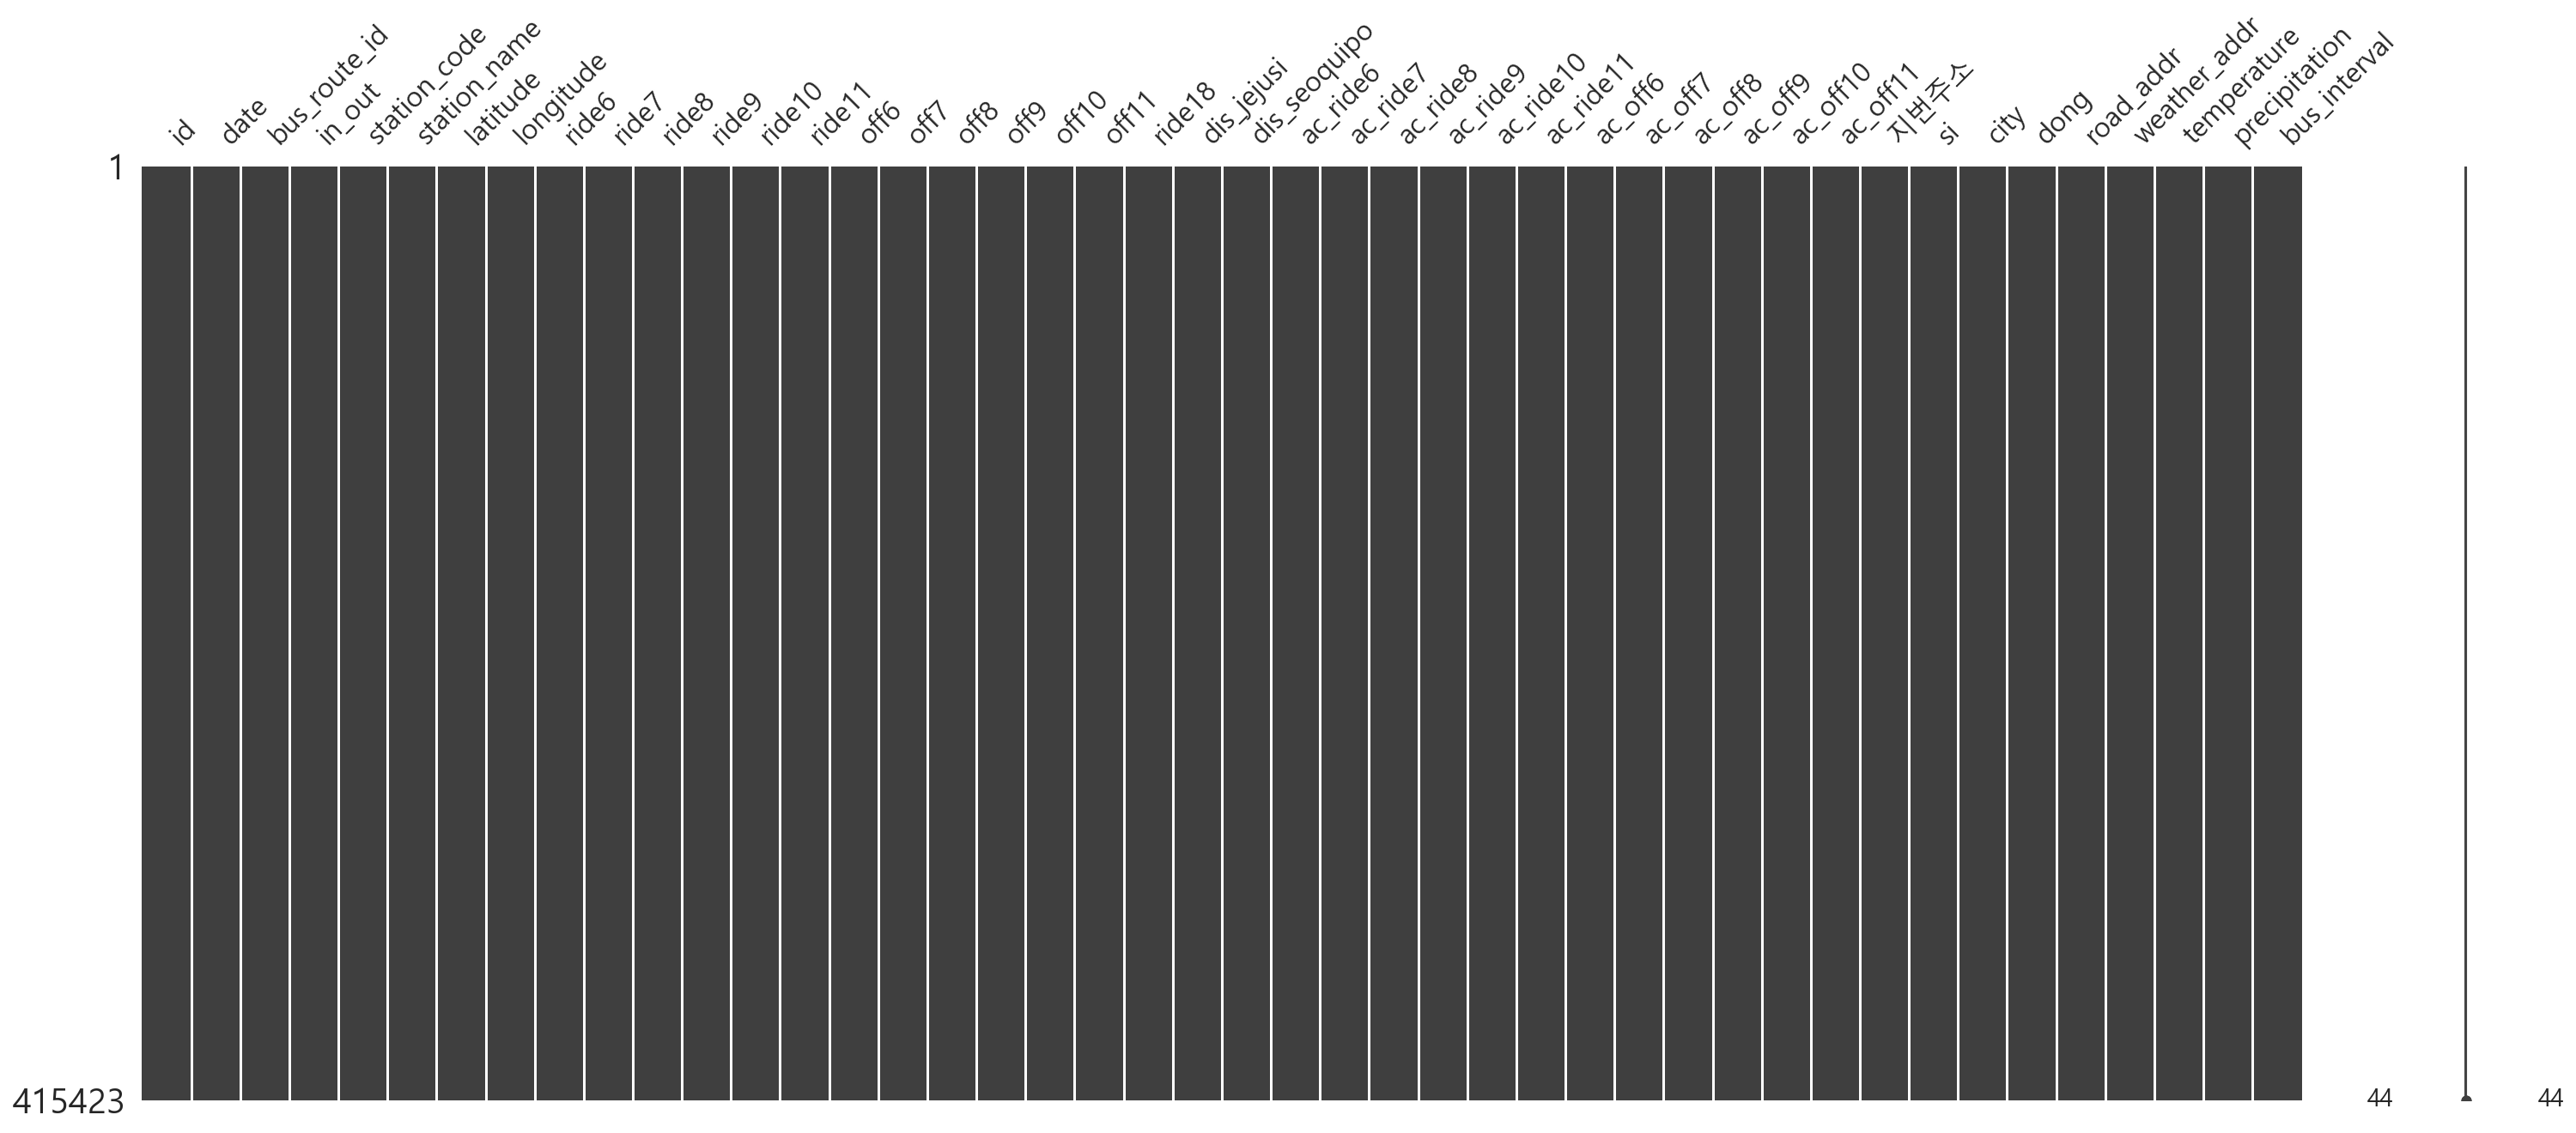

In [20]:
# 다시 Nan data 확인
missingno.matrix(train)
plt.show()

In [21]:
# 정확히 Nan값이 없는것을 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 44 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             415423 non-null  int64         
 1   date           415423 non-null  datetime64[ns]
 2   bus_route_id   415423 non-null  int64         
 3   in_out         415423 non-null  object        
 4   station_code   415423 non-null  int64         
 5   station_name   415423 non-null  object        
 6   latitude       415423 non-null  float64       
 7   longitude      415423 non-null  float64       
 8   ride6          415423 non-null  float64       
 9   ride7          415423 non-null  float64       
 10  ride8          415423 non-null  float64       
 11  ride9          415423 non-null  float64       
 12  ride10         415423 non-null  float64       
 13  ride11         415423 non-null  float64       
 14  off6           415423 non-null  float64       
 15  

#### 05. 원핫인코딩 (공휴일(추석), 평일, 주말, 시내, 시외, 태풍)

In [22]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())

# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.day_name()
train[['date','date_dayofweek','date_day','date_dayofname']]

# 평일과 휴일의 원핫 인코딩
train.loc[train['date_dayofweek'] == 0, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 1, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 2, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 3, 'weekday' ] = 1
train.loc[train['date_dayofweek'] == 4, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 5, 'weekday' ] = 0
train.loc[train['date_dayofweek'] == 6, 'weekday' ] = 0

#Weekend 주말
train.loc[train['date_dayofweek'] == 0, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 1, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 2, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 3, 'weekend' ] = 0
train.loc[train['date_dayofweek'] == 4, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 5, 'weekend' ] = 1
train.loc[train['date_dayofweek'] == 6, 'weekend' ] = 1

# 추석 추가도 공휴일로 처리
train['holiday'] = 0
train.loc[train['date'] == '2019-09-14', 'holiday'] = 1
train.loc[train['date'] == '2019-09-13', 'holiday'] = 1
train.loc[train['date'] == '2019-09-12', 'holiday'] = 1

# 태풍의 컬럼 추가
train['typhoon'] = 0
train.loc[train['date'] == '2019-09-06', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-07', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-21', 'typhoon'] = 1
train.loc[train['date'] == '2019-09-22', 'typhoon'] = 1

train.tail(2)

2019-09-01 00:00:00
2019-09-30 00:00:00


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1


In [23]:
# 시내, 시외 원핫 인코딩
in_out = pd.get_dummies(train['in_out'])
in_out.columns = ['in_', 'out']
train = pd.concat([train, in_out], axis = 1)
train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0


#### 06. 2시간 노선 생성

In [24]:
# 2시간 노선 만들기
train['ride67'] = train['ride6'] + train['ride7']
train['ride89'] = train['ride8'] + train['ride9']
train['ride1011'] = train['ride10'] + train['ride11']
train['off67'] = train['off6'] + train['off7']
train['off89'] = train['off8'] + train['off9']
train['off1011'] = train['off10'] + train['off11']

train['ac_ride67'] = train['ac_ride6'] + train['ac_ride7']
train['ac_ride89'] = train['ac_ride8'] + train['ac_ride9']
train['ac_ride1011'] = train['ac_ride10'] + train['ac_ride11']
train['ac_off67'] = train['ac_off6'] + train['ac_off7']
train['ac_off89'] = train['ac_off8'] + train['ac_off9']
train['ac_off1011'] = train['ac_off10'] + train['ac_off11']

train.tail(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011,ac_ride67,ac_ride89,ac_ride1011,ac_off67,ac_off89,ac_off1011
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 07. 탑승, 하차의 총합 만들기 (다만, 다중공선성 때문에 안쓰는게 좋을듯 합니다)

In [26]:
# 탑승의 총합 만들기
train['ride_sum'] = train['ride6'] + train['ride7'] + train['ride8'] + train['ride9'] + train['ride10'] + train['ride11']
train['ac_ride_sum'] = train['ac_ride6'] + train['ac_ride7'] + train['ac_ride8'] + train['ac_ride9'] + train['ac_ride10'] + train['ac_ride11']

In [27]:
# 하차의 총합만들기
train['off_sum'] = train['off6'] + train['off7'] + train['off8'] + train['off9'] + train['off10'] + train['off11']
train['ac_off_sum'] = train['ac_off6'] + train['ac_off7'] + train['ac_off8'] + train['ac_off9'] + train['ac_off10'] + train['ac_off11']

#### 08. 일별, 정류장별 버스노선 갯수 추가하기

In [28]:
# 일별, 정류장별 버스노선 갯수
station_table = pd.pivot_table(index=['station_code', 'date'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'date', 'bus_route_id_sum']
train = pd.merge(train, station_table, how='left', on=['station_code', 'date'])

# 정류장별 버스노선의 갯수
station_table = pd.pivot_table(index=['station_code'],values='bus_route_id', data=train, aggfunc=len).reset_index()
station_table.columns = ['station_code', 'bus_route_id_all_sum']
train = pd.merge(train, station_table, how='left', on=['station_code'])

train.tail(10)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,dis_jejusi,dis_seoquipo,ac_ride6,ac_ride7,ac_ride8,ac_ride9,ac_ride10,ac_ride11,ac_off6,ac_off7,ac_off8,ac_off9,ac_off10,ac_off11,지번주소,si,city,dong,road_addr,weather_addr,temperature,precipitation,bus_interval,date_day,date_dayofweek,date_dayofname,weekday,weekend,holiday,typhoon,in_,out,ride67,ride89,ride1011,off67,off89,off1011,ac_ride67,ac_ride89,ac_ride1011,ac_off67,ac_off89,ac_off1011,ride_sum,ac_ride_sum,off_sum,ac_off_sum,bus_route_id_sum,bus_route_id_all_sum
415413,292352,2019-09-22,27680000,시내,4127,용수리마을회관,33.32525,126.16874,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.253312,37.004573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4107-4,제주시,한경면,용수리,용수길,고산,20.5,34.1,77.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,24
415414,292356,2019-09-22,27700000,시내,3216,주전동,33.33602,126.17677,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.006417,36.528658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 1360-1,제주시,한경면,용수리,주전길,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1.0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,14
415415,292363,2019-09-22,27790000,시내,3547,상명리동동,33.36231,126.26957,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.111052,29.201601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한림읍 상명리 2361,제주시,한림읍,상명리,상명북2길,고산,20.5,34.1,66.0,22,6,Sunday,0.0,1.0,0,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,16
415416,292366,2019-09-22,27850000,시내,829,양돈단지,33.35997,126.30877,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.296282,25.767610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한림읍 금악리 1159-2,제주시,한림읍,금악리,금악북로,고산,20.5,34.1,21.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,8
415417,292413,2019-09-22,28150000,시내,3110,생각하는정원,33.32600,126.25526,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.540996,29.168375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 저지리 1529-2,제주시,한경면,저지리,녹차분재로,고산,20.5,34.1,64.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1,33
415418,292422,2019-09-22,28160000,시내,3264,제주평화박물관,33.30468,126.25663,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.953320,28.539001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 청수리 3389,제주시,한경면,청수리,청수로,고산,20.5,34.1,30.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,11
415419,292395,2019-09-22,27990000,시내,917,월림리,33.35477,126.26165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,29.187203,29.573776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한림읍 월림리 2108-2,제주시,한림읍,월림리,월림10길,고산,20.5,34.1,179.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,7
415420,293359,2019-09-22,29020000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,74.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2,13
415421,294340,2019-09-22,31590000,시내,2740,하모체육공원,33.21875,126.25229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.150631,28.867233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,제주특별자치도 서귀포시 대정읍 하모리 2148,서귀포시,대정읍,하모리,최남단해안로,고산,20.5,34.1,67.0,22,6,Sunday,0.0,1.0,0,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2,13
415422,292357,2019-09-22,27700000,시내,4122,붉으내,33.31893,126.17250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.317936,36.529457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,제주특별자치도 제주시 한경면 용수리 4719-1,제주시,한경면,용수리,한경해안로,고산,20.5,34.1,94.0,22,6,Sunday,0.0,1

#### 09. 마지막 확인 및 정리

In [29]:
# 컬럼별 값들의 갯수는?
for i in train.columns:
    print('{}의 개수는 {}'.format(i, len(train[i].unique())))

id의 개수는 415423
date의 개수는 30
bus_route_id의 개수는 613
in_out의 개수는 2
station_code의 개수는 3563
station_name의 개수는 1961
latitude의 개수는 3278
longitude의 개수는 3446
ride6의 개수는 47
ride7의 개수는 80
ride8의 개수는 78
ride9의 개수는 66
ride10의 개수는 66
ride11의 개수는 69
off6의 개수는 35
off7의 개수는 51
off8의 개수는 53
off9의 개수는 46
off10의 개수는 47
off11의 개수는 55
ride18의 개수는 170
dis_jejusi의 개수는 3563
dis_seoquipo의 개수는 3563
ac_ride6의 개수는 39
ac_ride7의 개수는 77
ac_ride8의 개수는 76
ac_ride9의 개수는 61
ac_ride10의 개수는 62
ac_ride11의 개수는 65
ac_off6의 개수는 34
ac_off7의 개수는 50
ac_off8의 개수는 51
ac_off9의 개수는 45
ac_off10의 개수는 45
ac_off11의 개수는 50
지번주소의 개수는 2774
si의 개수는 2
city의 개수는 14
dong의 개수는 178
road_addr의 개수는 727
weather_addr의 개수는 5
temperature의 개수는 62
precipitation의 개수는 66
bus_interval의 개수는 140
date_day의 개수는 30
date_dayofweek의 개수는 7
date_dayofname의 개수는 7
weekday의 개수는 2
weekend의 개수는 2
holiday의 개수는 2
typhoon의 개수는 2
in_의 개수는 2
out의 개수는 2
ride67의 개수는 98
ride89의 개수는 107
ride1011의 개수는 97
off67의 개수는 66
off89의 개수는 75
off1011의 개수는 84
ac_ride67의 개수는 90
ac_ride89의 개수는 

In [31]:
# 415423 rows × 71 columns
train = train.sort_values('id').reset_index(drop = True)
train.shape

(415423, 71)

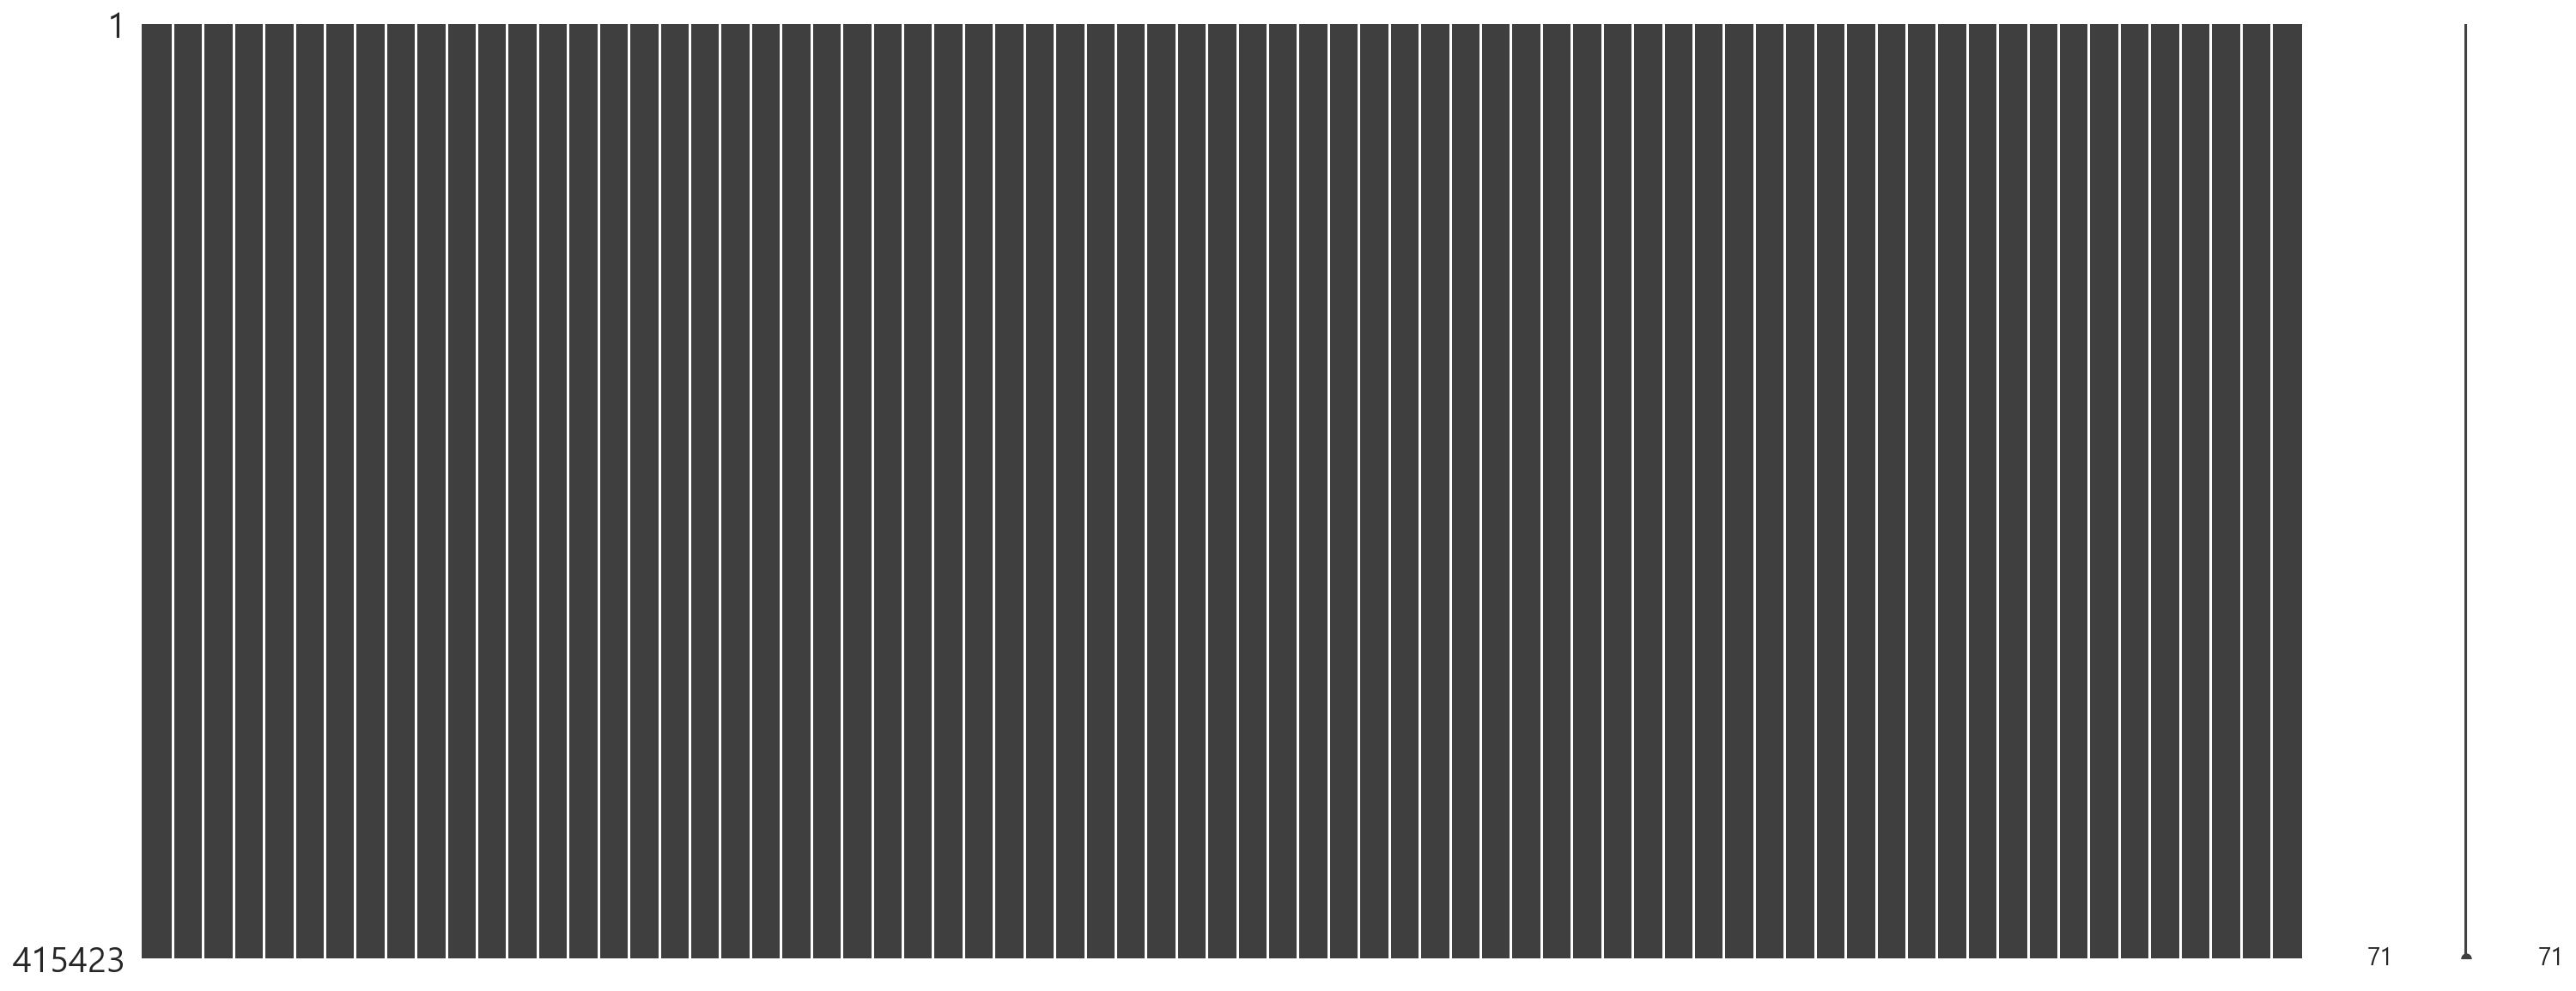

In [32]:
# nan값 확인
missingno.matrix(train)
plt.show()

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 71 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    415423 non-null  int64         
 1   date                  415423 non-null  datetime64[ns]
 2   bus_route_id          415423 non-null  int64         
 3   in_out                415423 non-null  object        
 4   station_code          415423 non-null  int64         
 5   station_name          415423 non-null  object        
 6   latitude              415423 non-null  float64       
 7   longitude             415423 non-null  float64       
 8   ride6                 415423 non-null  float64       
 9   ride7                 415423 non-null  float64       
 10  ride8                 415423 non-null  float64       
 11  ride9                 415423 non-null  float64       
 12  ride10                415423 non-null  float64       
 13 

In [34]:
# 데이터 저장
# 저장된 데이터를 드렸으니, 해당 행은 실행할 필요없습니다.
train.to_csv('raw_train.csv',encoding='utf-8',index = False)